# Data Collection and Exploration
This notebook loads, explores, and splits the cherry leaves dataset for mildew detection.

In [14]:
# Change working directory to the notebook's parent directory
import os
os.chdir(os.path.dirname(os.path.abspath("../jupyter_notebooks/DataCollection.ipynb")))
print(f"Current working directory: {os.getcwd()}")

Current working directory: /workspaces/mildew-detector/jupyter_notebooks


In [15]:
# Import required libraries
import os
import random
import shutil
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter

## Define dataset paths
Set the paths for healthy and powdery mildew images.

In [16]:
# Set dataset directories
data_dir = '../data/cherry-leaves'
healthy_dir = os.path.join(data_dir, 'healthy')
mildew_dir = os.path.join(data_dir, 'powdery_mildew')

## Count images in each class
Check the number of images for each class.

In [17]:
healthy_images = glob(os.path.join(healthy_dir, '*.JPG'))
mildew_images = glob(os.path.join(mildew_dir, '*.JPG'))
print(f'Healthy images: {len(healthy_images)}')
print(f'Powdery mildew images: {len(mildew_images)}')

Healthy images: 2104
Powdery mildew images: 2104


## Visualize sample images
Display a few random images from each class.

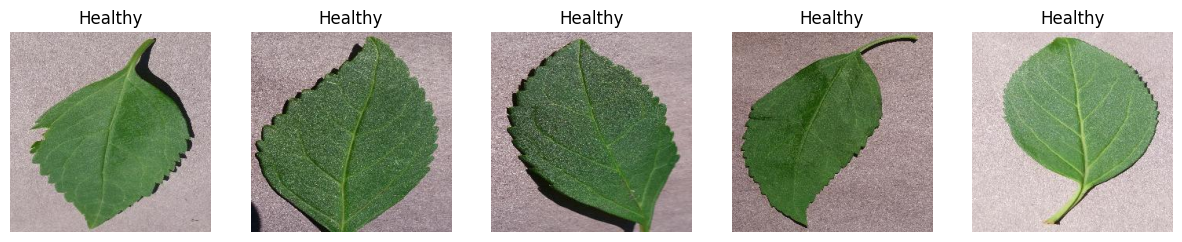

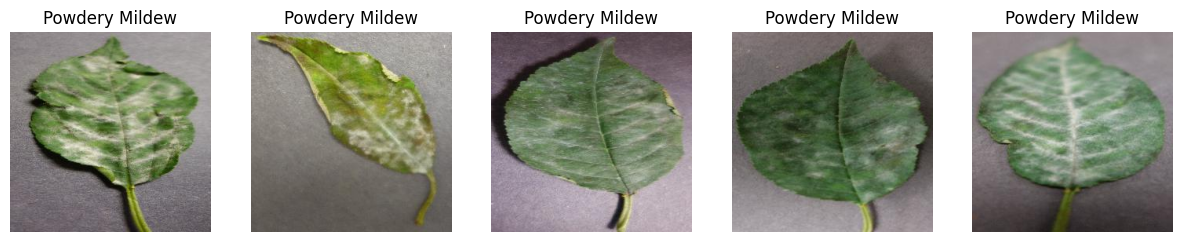

In [18]:
def show_samples(image_list, title, n=5):
    plt.figure(figsize=(15,3))
    for i, img_path in enumerate(random.sample(image_list, n)):
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

show_samples(healthy_images, 'Healthy', n=5)
show_samples(mildew_images, 'Powdery Mildew', n=5)

## Split dataset into train, validation, and test sets
Organize images into train (70%), val (15%), and test (15%) folders.

In [19]:
def split_and_copy(images, out_dir, split_fracs=(0.7, 0.15, 0.15)):
    random.shuffle(images)
    n = len(images)
    n_train = int(split_fracs[0] * n)
    n_val = int(split_fracs[1] * n)
    train, val, test = images[:n_train], images[n_train:n_train+n_val], images[n_train+n_val:]
    for split, split_images in zip(['train', 'val', 'test'], [train, val, test]):
        split_dir = os.path.join(out_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        for img_path in split_images:
            shutil.copy(img_path, split_dir)
    return len(train), len(val), len(test)

# Output directories
output_base = '../out/split'
for label, images in [('healthy', healthy_images), ('powdery_mildew', mildew_images)]:
    out_dir = os.path.join(output_base, label)
    n_train, n_val, n_test = split_and_copy(images, out_dir)
    print(f'{label}: train={n_train}, val={n_val}, test={n_test}')

healthy: train=1472, val=315, test=317
powdery_mildew: train=1472, val=315, test=317
powdery_mildew: train=1472, val=315, test=317


## Data Augmentation
To increase the diversity of the training data, we will use image augmentation techniques such as rotation, flipping, and zooming.

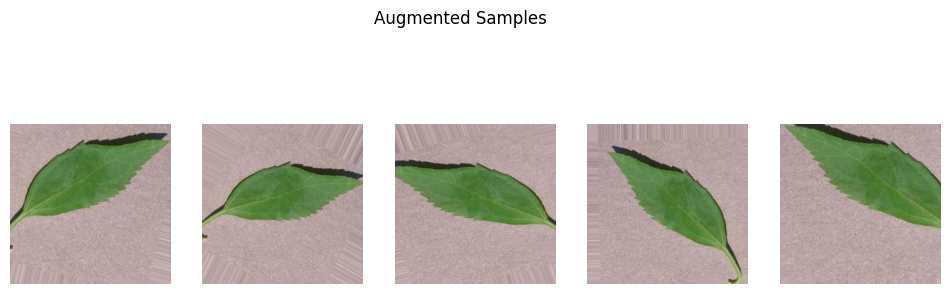

In [20]:
# Data augmentation example using Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation parameters
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Pick a sample image from the training set
sample_dir = '../out/split/healthy/train'
sample_img_path = os.path.join(sample_dir, os.listdir(sample_dir)[0])
img = Image.open(sample_img_path)
img_array = np.array(img)
img_array = img_array.reshape((1,) + img_array.shape)

# Generate and plot augmented images
plt.figure(figsize=(12,4))
for i, batch in enumerate(augmenter.flow(img_array, batch_size=1)):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    if i == 4:
        break
plt.suptitle('Augmented Samples')
plt.show()

## Prepare Data for Modeling
Load the split images and create data generators for training, validation, and testing.

In [ ]:
# Create ImageDataGenerators for train, validation, and test sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set directories
train_dir = '../out/split/healthy/train'
val_dir = '../out/split/healthy/val'
test_dir = '../out/split/healthy/test'

# For multi-class, use the parent directory
base_dir = '../out/split'

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, ''),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, ''),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, ''),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print('Data generators are ready.')